TP1 INF6804 HOG

Imports

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [17]:
image_query_name = "./TP1_data/lotus_query.jpg"
image = cv2.imread(image_query_name, cv2.IMREAD_GRAYSCALE)

# Set HOG descriptor parameters
win_size = (256, 256)      # Size of the window (image patch)
block_size = (16, 16)    # Size of each block
block_stride = (8, 8)    # Step size to move the block
cell_size = (8, 8)       # Size of each cell within a block
nbins = 9                # Number of histogram bins

# Create the HOG descriptor object
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

# Resize the image to match the HOG descriptor window size
image_resized = cv2.resize(image, win_size)

# Compute the HOG descriptor for the entire image
hog_features = hog.compute(image_resized)
print(hog_features.shape)

# Compute the number of blocks
n_blocks_x = (win_size[0] - block_size[0]) // block_stride[0] + 1
n_blocks_y = (win_size[1] - block_size[1]) // block_stride[1] + 1
n_blocks = n_blocks_x * n_blocks_y
print(n_blocks)
# Reshape the HOG features into blocks
hog_features_per_block = np.reshape(hog_features, (n_blocks, -1))
print(hog_features_per_block.shape)


(34596,)
961
(961, 36)


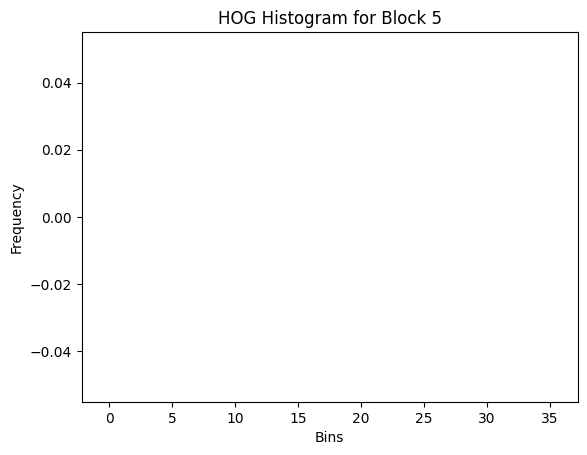

In [18]:
# Plot the histogram for the first block as an example
block_index = 5 # Choose the block to visualize
plt.bar(range(hog_features_per_block.shape[1]), hog_features_per_block[block_index])
plt.title(f'HOG Histogram for Block {block_index}')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

In [7]:
def compute_dist(image_name1,image_name2):
    # Set HOG descriptor parameters
    win_size = (256, 256)      # Size of the window (image patch)
    block_size = (16, 16)    # Size of each block
    block_stride = (8, 8)    # Step size to move the block
    cell_size = (8, 8)       # Size of each cell within a block
    nbins = 9                # Number of histogram bins

    # Create the HOG descriptor object
    
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    image1 = cv2.imread(image_name1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_name2, cv2.IMREAD_GRAYSCALE)
    # Resize the image to match the HOG descriptor window size
    image_resized1 = cv2.resize(image1, win_size)
    image_resized2 = cv2.resize(image2, win_size)

    # Compute the HOG descriptor for the images
    hog_features1 = hog.compute(image_resized1)
    hog_features2 = hog.compute(image_resized2)

    #Compute the distance between the two HOG descriptors
    dist = np.linalg.norm(hog_features1-hog_features2)
    return dist

def compute_dist_all(image_query_name):
    list_dist = []
    for file_name in os.listdir("./TP1_data/database"):
        if file_name.endswith(".jpg"):
            
            dist = compute_dist(image_query_name,"./TP1_data/database/"+file_name)
            list_dist.append((file_name,dist))
    return list_dist

In [8]:
list_dist = compute_dist_all(image_query_name)
short_list = sorted(list_dist, key=lambda x: x[1])[:5]
print(short_list)

[('lotus_3.jpg', 26.738867), ('dolphin_5.jpg', 26.948854), ('cat_4.jpg', 26.976068), ('airplane_1.jpg', 27.022568), ('lotus_1.jpg', 27.154217)]
